# Anomaly detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
data_train = pd.read_table('ex8data1.txt', sep=',', header=None, dtype=np.float32)
data_train

,0,1
0,13.046815,14.741153
1,13.408520,13.763269
2,14.195915,15.853181
3,14.914701,16.174259
4,13.576699,14.042850
...,...,...
302,12.476629,14.459370
303,19.582573,10.411619
304,23.339867,16.298874
305,18.261189,17.978310


In [3]:
data_val = pd.read_table('ex8data2.txt', sep=',', header=None, dtype=np.float32)
data_val

,0,1,2
0,15.790259,14.921024,0.0
1,13.639619,15.329955,0.0
2,14.865899,16.473866,0.0
3,13.584676,13.989306,0.0
4,13.464042,15.635330,0.0
...,...,...,...
302,0.307938,5.391413,1.0
303,28.541786,21.599775,1.0
304,19.034988,12.028949,1.0
305,14.375779,23.355972,1.0


In [4]:
X_train = data_train.values

X_val = data_val.iloc[:,[0,1]].values
Y_val = data_val.iloc[:,[2]].values

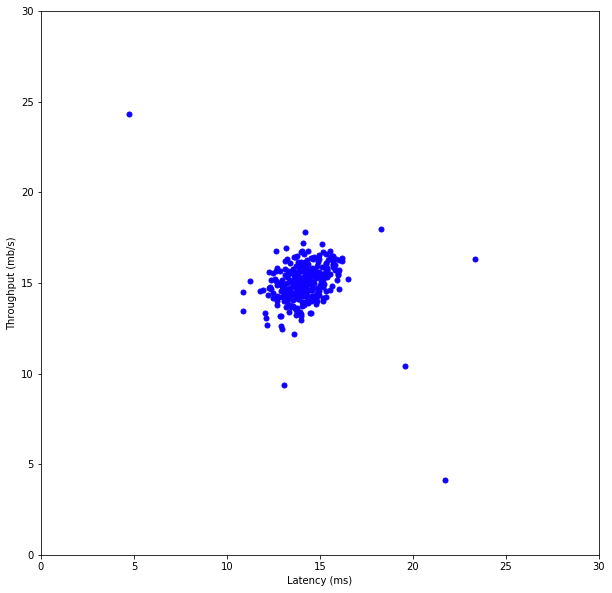

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([0, 30, 0, 30])
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.plot(X_train[:,0], X_train[:,1], marker='.', color='#0F00FF', markersize=10, linestyle='') 

In [6]:
class AnomalyDetection():
    
    def __call__(self, inputs):
        x = inputs-self.mu
        b_x = np.transpose(np.dot(self.beta,np.transpose(x)))
        y = (-1/2)*np.sum(x*b_x, axis=1, keepdims=True)
        k = np.power(2*np.pi,-inputs.shape[1]/2)*np.power(self.det_beta,1/2)
        return k*np.exp(y)
    
    def predict(self, inputs):
        return self(inputs)
             
    def fit(self, X_train):
        self.mu = np.expand_dims(np.mean(X_train, axis=0), axis=0)
        m = X_train.shape[0]
        print('Training...')
        start_time = time.time()
        self.sigma = (1/m)*np.dot(np.transpose(X_train-self.mu), X_train-self.mu)
        self.beta = np.linalg.inv(self.sigma)   
        self.det_beta = np.linalg.det(self.beta)
        now = time.time()
        duration = now - start_time
        print('----- {}s -----'.format(np.round(1000*duration)/1000))

In [7]:
model = AnomalyDetection()

model.fit(X_train)

Training...
----- 0.01s -----


In [8]:
model.mu

array([[14.112226, 14.997709]], dtype=float32)

In [9]:
model.beta

array([[0.55479705, 0.07369919],
       [0.07369919, 0.5946727 ]], dtype=float32)

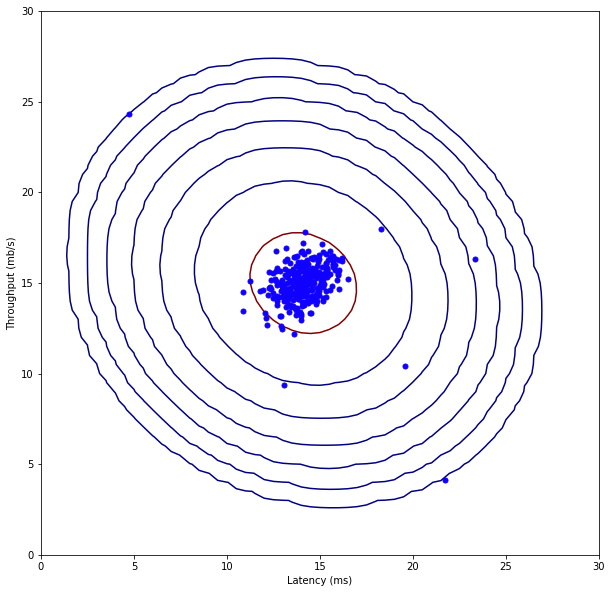

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([0, 30, 0, 30])
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.plot(X_train[:,0], X_train[:,1], marker='.', color='#0F00FF', markersize=10, linestyle='')
levels = np.power(10,np.linspace(-20, -2, 7))
I = np.arange(0, 35.5, 0.5)
k = I.size
X1,X2 = np.meshgrid(I,I)
D = np.array([X1.flatten(), X2.flatten()]).T
Z = model.predict(D) 
ax.contour(X1, X2, Z.reshape((k,k)), levels, cmap='jet')

In [11]:
Y_pred_val = model.predict(X_val)
Y_pred_val

array([[4.1836392e-02],
       [8.3422735e-02],
       [3.7324890e-02],
       [5.9642375e-02],
       [7.3711373e-02],
       [4.6601605e-02],
       [5.9360430e-02],
       [8.5220784e-02],
       [1.8561337e-02],
       [7.7853881e-02],
       [7.9217963e-02],
       [4.1769382e-02],
       [5.6574084e-02],
       [1.1289458e-02],
       [5.7561655e-02],
       [4.0047791e-02],
       [4.7310278e-02],
       [5.5931006e-02],
       [7.5412847e-02],
       [4.1860811e-02],
       [8.7967984e-02],
       [3.0585863e-02],
       [8.5245922e-02],
       [7.1681462e-02],
       [7.5837053e-02],
       [8.4416360e-02],
       [3.9809652e-02],
       [7.3497325e-02],
       [3.9108835e-02],
       [6.8529032e-02],
       [8.4465347e-02],
       [6.3758381e-02],
       [7.3089562e-02],
       [8.9470059e-02],
       [6.4223759e-02],
       [7.2700039e-02],
       [6.4354077e-02],
       [2.0105138e-02],
       [5.4622594e-02],
       [8.7784052e-02],
       [5.3861491e-02],
       [3.357487

In [12]:
bestEpsilon = 0
bestF1 = 0
F1 = 0
stepsize = (np.max(Y_pred_val.flatten())-np.min(Y_pred_val.flatten()))/1000
for epsilon in np.arange(np.min(Y_pred_val.flatten()), np.max(Y_pred_val.flatten()), stepsize):
    predictions = Y_pred_val.flatten()<epsilon
    tp_vector = (Y_val.flatten() == 1) & (predictions == 1)
    fp_vector = (Y_val.flatten() == 0) & (predictions == 1)
    fn_vector = (Y_val.flatten() == 1) & (predictions == 0)
    tp = np.sum(tp_vector)
    fp = np.sum(fp_vector)
    fn = np.sum(fn_vector)
    if (tp!=0) and ((tp+fp)!=0) and ((tp+fn)!=0):
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = 2*prec*rec/(prec+rec)
    if F1 > bestF1:
        bestF1 = F1
        bestEpsilon = epsilon

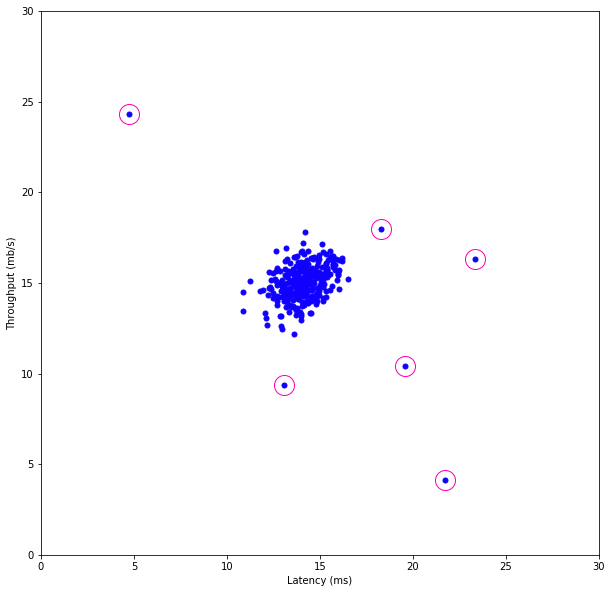

In [13]:
Z = model.predict(X_train).flatten()
outliers = np.argwhere(Z < bestEpsilon)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([0, 30, 0, 30])
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.plot(X_train[:,0], X_train[:,1], marker='.', color='#0F00FF', markersize=10, linestyle='')
ax.plot(X_train[outliers,0], X_train[outliers,1], marker='o',color='#FF00AE', linewidth=2, markersize=20, linestyle='', fillstyle='none')

-----

In [14]:
data_train = pd.read_table('ex8data3.txt', sep=',', header=None, dtype=np.float32)
data_train

,0,1,2,3,4,5,6,7,8,9,10
0,6.653114,13.689702,17.552845,-11.933497,-5.756409,15.435922,-12.136752,8.224123,-4.884024,5.349335,17.351372
1,-5.630542,-18.937668,18.644625,-6.155825,-25.988863,15.409554,-16.595516,9.454654,-2.877173,-6.009420,19.210636
2,9.721525,-9.982489,15.571434,-32.224266,-5.595799,24.321383,0.832774,10.794555,0.727575,10.392975,7.085995
3,-4.635766,-10.716040,20.356571,-9.002097,-4.920569,-4.261958,-1.305829,0.949980,-8.634107,0.198445,0.006771
4,-12.841044,-20.388313,9.491937,-7.038500,-9.921087,-3.716105,-9.384730,-2.325534,-13.518562,11.007029,14.003210
...,...,...,...,...,...,...,...,...,...,...,...
995,8.387860,-10.076271,21.569830,-12.566014,-8.880607,8.340489,-12.872152,9.758749,-9.554969,7.845717,2.193613
996,3.059507,-5.926298,31.837423,0.245340,10.050776,-1.997428,2.059448,12.571625,4.110159,14.815644,9.035330
997,5.420209,-5.109845,12.192200,-0.824891,-11.061356,15.105683,0.621229,-8.247540,-13.899425,9.418016,1.841384
998,11.604732,-9.134174,19.582518,-8.309882,-10.182652,19.410673,-11.029716,21.424522,1.014265,-0.784065,6.217904


In [15]:
data_val = pd.read_table('ex8data4.txt', sep=',', header=None, dtype=np.float32)
data_val

,0,1,2,3,4,5,6,7,8,9,10,11
0,18.271282,-12.359268,5.000969,1.611472,1.088593,29.314409,-8.313531,36.438339,-9.476679,-25.928183,7.108628,1.0
1,-3.193070,-19.705820,6.528555,-21.570858,3.050556,23.477503,-1.133420,12.688410,-10.968301,-1.198666,1.908441,0.0
2,-5.256678,-12.918720,25.435141,-7.231568,3.647838,12.366549,-6.512076,8.750902,-0.768755,-3.261095,13.729474,0.0
3,12.953176,-10.350332,19.857857,-24.424608,3.266105,30.445295,-11.125842,12.815629,9.351355,-6.113624,17.627375,1.0
4,3.763819,-5.728187,11.400168,-17.555298,-6.246576,16.155970,-9.724757,16.996616,-5.168654,0.187994,11.401234,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.928511,-22.950802,18.913328,4.279605,-11.798425,10.344051,-1.077825,17.325335,-10.480398,9.934596,10.532460,0.0
96,7.039219,-14.193847,18.055122,-16.635221,2.093759,32.706367,-0.430254,8.994538,-1.397071,-1.711708,13.712861,0.0
97,-5.194643,-17.116600,3.526259,-9.626143,-10.062796,17.029116,-10.339141,21.162552,-10.591516,2.007690,0.724487,0.0
98,8.415389,-11.172920,35.802845,0.326202,-6.668745,17.642431,4.975742,-2.422990,-0.413698,4.078936,16.039303,0.0


In [16]:
X_train = data_train.values

X_val = data_val.iloc[:,:11].values
Y_val = data_val.iloc[:,[11]].values

In [17]:
model = AnomalyDetection()

model.fit(X_train)

Training...
----- 0.001s -----


In [18]:
model.mu

array([[  4.9394   ,  -9.637269 ,  13.814707 , -10.464488 ,  -7.956229 ,
         10.199504 ,  -6.0194073,   7.9698286,  -6.2531815,   2.324513 ,
          8.473722 ]], dtype=float32)

In [19]:
model.beta

array([[ 1.6789868e-02, -5.8932812e-04, -1.3683700e-04,  2.9193952e-05,
        -1.2720878e-03,  6.6053151e-05,  1.2458238e-03, -9.9469861e-04,
         8.9029997e-04, -8.6286425e-04,  1.1651666e-03],
       [-5.8932812e-04,  1.9956538e-02,  8.7462174e-04,  9.8192866e-04,
        -6.0408376e-04, -5.3294009e-04, -9.2640606e-04, -1.5619782e-03,
        -2.5170995e-03,  1.2246633e-03, -2.9019201e-03],
       [-1.3683700e-04,  8.7462174e-04,  1.8059928e-02, -6.4204249e-04,
        -7.1007060e-04,  6.2801276e-04, -9.5518789e-04, -3.9626585e-04,
        -4.7050822e-03, -1.4004899e-03,  9.6393737e-04],
       [ 2.9193952e-05,  9.8192866e-04, -6.4204249e-04,  1.2101224e-02,
        -3.1050137e-04, -2.2561458e-04, -7.4277393e-04, -5.2242511e-04,
         1.7559795e-03, -2.1477047e-04, -2.4192997e-05],
       [-1.2720878e-03, -6.0408376e-04, -7.1007060e-04, -3.1050137e-04,
         1.5682857e-02, -2.1732468e-04, -1.5406635e-03,  5.8540388e-04,
        -3.9438903e-04, -8.2717207e-04, -4.0358271e-

In [20]:
Y_pred_val = model.predict(X_val)
Y_pred_val

array([[6.51313856e-22],
       [1.31855170e-17],
       [9.29275413e-17],
       [1.68532285e-19],
       [1.75384810e-15],
       [1.25114945e-16],
       [5.27658616e-19],
       [1.77611245e-17],
       [3.92746864e-16],
       [8.03191157e-16],
       [1.02018078e-16],
       [3.90814043e-19],
       [2.06395552e-16],
       [3.57629936e-16],
       [9.87299552e-17],
       [2.45841757e-16],
       [4.83672323e-17],
       [5.62321192e-16],
       [1.03369270e-17],
       [4.00832829e-26],
       [3.63533141e-17],
       [9.90006947e-17],
       [8.05013165e-17],
       [1.44411938e-17],
       [3.88312825e-17],
       [4.27930627e-16],
       [7.88747353e-17],
       [5.99844153e-23],
       [2.53768143e-17],
       [6.85329519e-18],
       [4.58762681e-18],
       [1.43744257e-16],
       [3.67418752e-16],
       [3.11352726e-18],
       [6.21090166e-19],
       [1.34090887e-16],
       [1.89098782e-16],
       [6.64513163e-17],
       [5.00952614e-18],
       [1.34930396e-17],


In [21]:
bestEpsilon = 0
bestF1 = 0
F1 = 0
stepsize = (np.max(Y_pred_val.flatten())-np.min(Y_pred_val.flatten()))/1000
for epsilon in np.arange(np.min(Y_pred_val.flatten()), np.max(Y_pred_val.flatten()), stepsize):
    predictions = Y_pred_val.flatten()<epsilon
    tp_vector = (Y_val.flatten() == 1) & (predictions == 1)
    fp_vector = (Y_val.flatten() == 0) & (predictions == 1)
    fn_vector = (Y_val.flatten() == 1) & (predictions == 0)
    tp = np.sum(tp_vector)
    fp = np.sum(fp_vector)
    fn = np.sum(fn_vector)
    if (tp!=0) and ((tp+fp)!=0) and ((tp+fn)!=0):
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = 2*prec*rec/(prec+rec)
    if F1 > bestF1:
        bestF1 = F1
        bestEpsilon = epsilon

In [22]:
Y_pred = model.predict(X_train)
np.sum(Y_pred.flatten() < bestEpsilon)

122